In [144]:
import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import pandas as pd 
import numpy as np
import math
from tqdm import tqdm

In [145]:
pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 3.pdf"
doc = fitz.open(pdf_dir)
pages = [doc[i] for i in range(doc.pageCount)]
index = list(range(555, 583))

TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

In [146]:
def initiate_groups(row):
    #return row
    x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
    word_no = row['word_no']
    word = row['word']
    alphnum_word = ''.join(e for e in word if e.isalnum())
    
    if (word_no == 0): #and (not alphnum_word.isnumeric()):
        #word_no == 0 => the word is a Family, Genus, Species
        new_group = True
        for g in indent_groups:
            g_arr = np.array(g)[:,0]
            if (x_0, y_0, x_1, y_1)[0] <= np.mean(g_arr) + indent_err and (x_0, y_0, x_1, y_1)[0] >= np.mean(g_arr) - indent_err:
                g.append((x_0, y_0, x_1, y_1))
                new_group = False
        if new_group:
            indent_groups.append([(x_0, y_0, x_1, y_1)])

def get_indent_group(row):
    x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
    word_no = row['word_no']
    word = row['word']
    alphnum_word = ''.join(e for e in word if e.isalnum())
    
    if (not alphnum_word.isnumeric()): 
        for g_i, g in enumerate(indent_groups):
            g_arr = np.array(g)[:,0]
            if (x_0, y_0, x_1, y_1)[0] <= np.mean(g_arr) + indent_err and (x_0, y_0, x_1, y_1)[0] >= np.mean(g_arr) - indent_err:
                return g_i

def get_col(row): 
    x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
    return int(x_0 > ((x_min + x_max) / 2))

In [147]:
test = pd.DataFrame(pages[0].get_text_words(), columns =['in_x0', 'in_y0', 'in_x1', 'in_y1', 'word', 'block_no', 'line_no', 'word_no'])

In [148]:
def process_df(page_num, genus = np.NaN, genus_block_no = np.NaN):
    def initiate_groups(row):
        #return row
        x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
        word_no = row['word_no']
        word = row['word']
        alphnum_word = ''.join(e for e in word if e.isalnum())
        
        if (word_no == 0) and (not alphnum_word.isnumeric()):
            #word_no == 0 => the word is a Family, Genus, Species
            new_group = True
            for g in indent_groups:
                g_arr = np.array(g)[:,0]
                if (x_0, y_0, x_1, y_1)[0] <= np.mean(g_arr) + indent_err and (x_0, y_0, x_1, y_1)[0] >= np.mean(g_arr) - indent_err:
                    g.append((x_0, y_0, x_1, y_1))
                    new_group = False
            if new_group:
                indent_groups.append([(x_0, y_0, x_1, y_1)])

    def get_indent_group(row):
        x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
        word_no = row['word_no']
        word = row['word']
        alphnum_word = ''.join(e for e in word if e.isalnum())
        
        if (len(word) > 1) and ((not alphnum_word.isnumeric()) and (word_no == 0)): 
            for g_i, g in enumerate(indent_groups):
                g_arr = np.array(g)[:,0]
                if (x_0, y_0, x_1, y_1)[0] <= np.mean(g_arr) + indent_err and (x_0, y_0, x_1, y_1)[0] >= np.mean(g_arr) - indent_err:
                    return g_i

    def get_col(row): 
        x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
        return int(x_0 > ((x_min + x_max) / 2))

    def n_leftmost_indent(indent_groups, n):
        indent_means = []
        for g_i, g in enumerate(indent_groups):
            g_arr = np.array(g)[:,0]
            indent_means.append([g_i, np.mean(g_arr)])

        n_smallest = indent_means.sort(key = lambda x : x[1])[:n] #n smallest
        return [el[0] for el in n_smallest]

    def process_col(row):
        nonlocal genus
        nonlocal x_0, y_0, x_1, y_1 
        nonlocal epitet
        nonlocal genus_block_no
        word_no = row['word_no']
        block_no = row['block_no']
        line_no = row['line_no']
        word = row['word']
        
        alph_word = ''.join(e for e in word if e.isalpha())

        if (not (word.isupper() and word_no == 0)):
            if word_no == 0: #epitet, or genus
                x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
                
            alphnum_word = ''.join(e for e in word if e.isalnum())
            if (not alphnum_word.isnumeric()): 
                if  x_0 <= g_x0 + indent_err and x_0 >= g_x0 - indent_err:
                    if word_no == 0:
                        genus = word
                        row['genus'] = genus
                        genus_block_no = row['block_no']
                    elif word_no != 0 and line_no == 0 and block_no == genus_block_no: #info on same line as genus
                        #epitet = word
                        #print(genus, alphnum_word)
                        row['epitet'] = np.NaN
                        row['genus'] = genus
                        #row['author']"""
                    else:
                        row['epitet'] = epitet
                        row['genus'] = genus
                elif x_0 <= s_x0 + indent_err and x_0 >= s_x0 - indent_err:
                    if word_no == 0:
                        epitet = word
                    row['epitet'] = epitet
                    row['genus'] = genus
        return row

    page_df = pd.DataFrame(pages[page_num].get_text_words(), columns =['in_x0', 'in_y0', 'in_x1', 'in_y1', 'word', 'block_no', 'line_no', 'word_no'])
    page_df['page_num'] = np.array([page_num]*page_df.shape[0])
    page_df['x0'], page_df['y0'], page_df['x1'], page_df['y1'] = page_df['in_x0']*TARGET_DPI/ 72, page_df['in_y0']*TARGET_DPI/ 72, page_df['in_x1']*TARGET_DPI/ 72, page_df['in_y1']*TARGET_DPI/ 72
    indent_groups = []
    indent_err = 15

    x_min = page_df['x0'].min()
    y_min = page_df['y0'].min()
    x_max = page_df['x1'].max()
    y_max = page_df['y1'].max()
    
    page_df.apply(initiate_groups, axis = 1)
    page_df['indent_group'] = page_df.apply(get_indent_group, axis = 1)

    page_df['col'] = page_df.apply(get_col, axis = 1)
    
    x_0, y_0, x_1, y_1, epitet = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
    for c in page_df['col'].unique():
        
        # what if just one largest? what would that even mean? Hm ... (like what if it's all)
        col_df = page_df[(page_df['col'] == c)]
        col_indent_groups =  list(col_df[~col_df['indent_group'].isnull()]['indent_group'].unique())
        #n_leftmost = n_leftmost_indent(col_indent_groups, 2)
        #col_df[col_df['indent_group'] == s_indent]
        #if len(n_leftmost) == 2:

        s_x0, g_x0 = float('inf'), float('inf')
        s_indent, g_indent = -1, -1

        for g in col_indent_groups:
            mean_x0 = col_df[col_df['indent_group'] == g]['x0'].mean()
            if g_x0 > mean_x0:
                s_indent, g_indent = g_indent, g
                s_x0, g_x0 = g_x0, mean_x0 
            elif s_x0 > mean_x0: #and g_x0 <= mean_x0
                s_indent = g
                s_x0 = mean_x0

        #if col_df[col_df['indent_group'] == s_indent]['word'].str.contains('var.|subsp.').any():
        species_indent_df = col_df[col_df['indent_group'] == s_indent]
        if (species_indent_df['word'] == 'var.').any() or (species_indent_df['word'] == 'subsp.').any():
            s_x0, g_x0 = g_x0, float('inf')
            s_indent, g_indent = g_indent, -1
            #print("no genus in a column of page", page_num)
            
        col_df = col_df.apply(process_col, axis = 1)
        page_df.loc[col_df.index, ['genus', 'epitet']] = col_df.loc[col_df.index, ['genus', 'epitet']]
        
    return page_df, genus

In [149]:
test_df0, g0 = process_df(0)
test_df1, g1 = process_df(1, g0)

In [150]:
def plot_genus_blocks(page_df, draw, color = '#6c899e', w = 3):
    genus_list = page_df['genus'].unique()
    for c in page_df['col'].unique():
        for g in genus_list:
            temp_df = page_df[(page_df['col'] == c) & (page_df['genus'] == g)]
            g_x0 = temp_df['x0'].min()
            g_y0 = temp_df['y0'].min()
            g_x1 = temp_df['x1'].max()
            g_y1 = temp_df['y1'].max()

            draw.rectangle((g_x0, g_y0, g_x1, g_y1), fill=None, outline=ImageColor.getrgb(color), width = w)
        
def plot_epitet_blocks(page_df, draw, color = '#54081f', w = 2):
    epitet_list = page_df['epitet'].unique()
    for c in page_df['col'].unique():
        for s in epitet_list:
            temp_df = page_df[(page_df['col'] == c) & (page_df['epitet'] == s)]
            for g in temp_df['genus'].unique():
                    
                temp_g_df = temp_df[(temp_df['genus']) == g]
                s_x0 = temp_g_df['x0'].min()
                s_y0 = temp_g_df['y0'].min()
                s_x1 = temp_g_df['x1'].max()
                s_y1 = temp_g_df['y1'].max()

                draw.rectangle((s_x0, s_y0, s_x1, s_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

def plot_blocks(page_df, draw, color = '#4a3757', w = 2):
    block_list = page_df['block_no'].unique()
    #temp_df = page_df[(page_df['col'] == c) & (page_df['epitet'] == s)]
    #df_groupped = page_df.groupby(['block_no'])
    for i in block_list:
        df_groupped = page_df[page_df['block_no'] == i]
        x0_arr = df_groupped['x0'].min()
        y0_arr = df_groupped['y0'].min()
        x1_arr = df_groupped['x1'].max()
        y1_arr = df_groupped['y1'].max()

        #boundries = x0_arr.loc[i], y0_arr.loc[i], x1_arr.loc[i], y1_arr.loc[i]
        draw.rectangle((x0_arr, y0_arr, x1_arr, y1_arr), fill=None, outline=ImageColor.getrgb(color), width = w)


In [151]:
test_df0, g0 = process_df(0)
test_df1, g1 = process_df(1, g0)

pix_map0 = doc.get_page_pixmap(0,matrix=mat)
image0 = Image.open(io.BytesIO(pix_map0.tobytes()))
draw0 = ImageDraw.Draw(image0)

plot_genus_blocks(test_df0, draw0)
plot_epitet_blocks(test_df0, draw0)

In [152]:
#plot_blocks(test_df0, draw0)

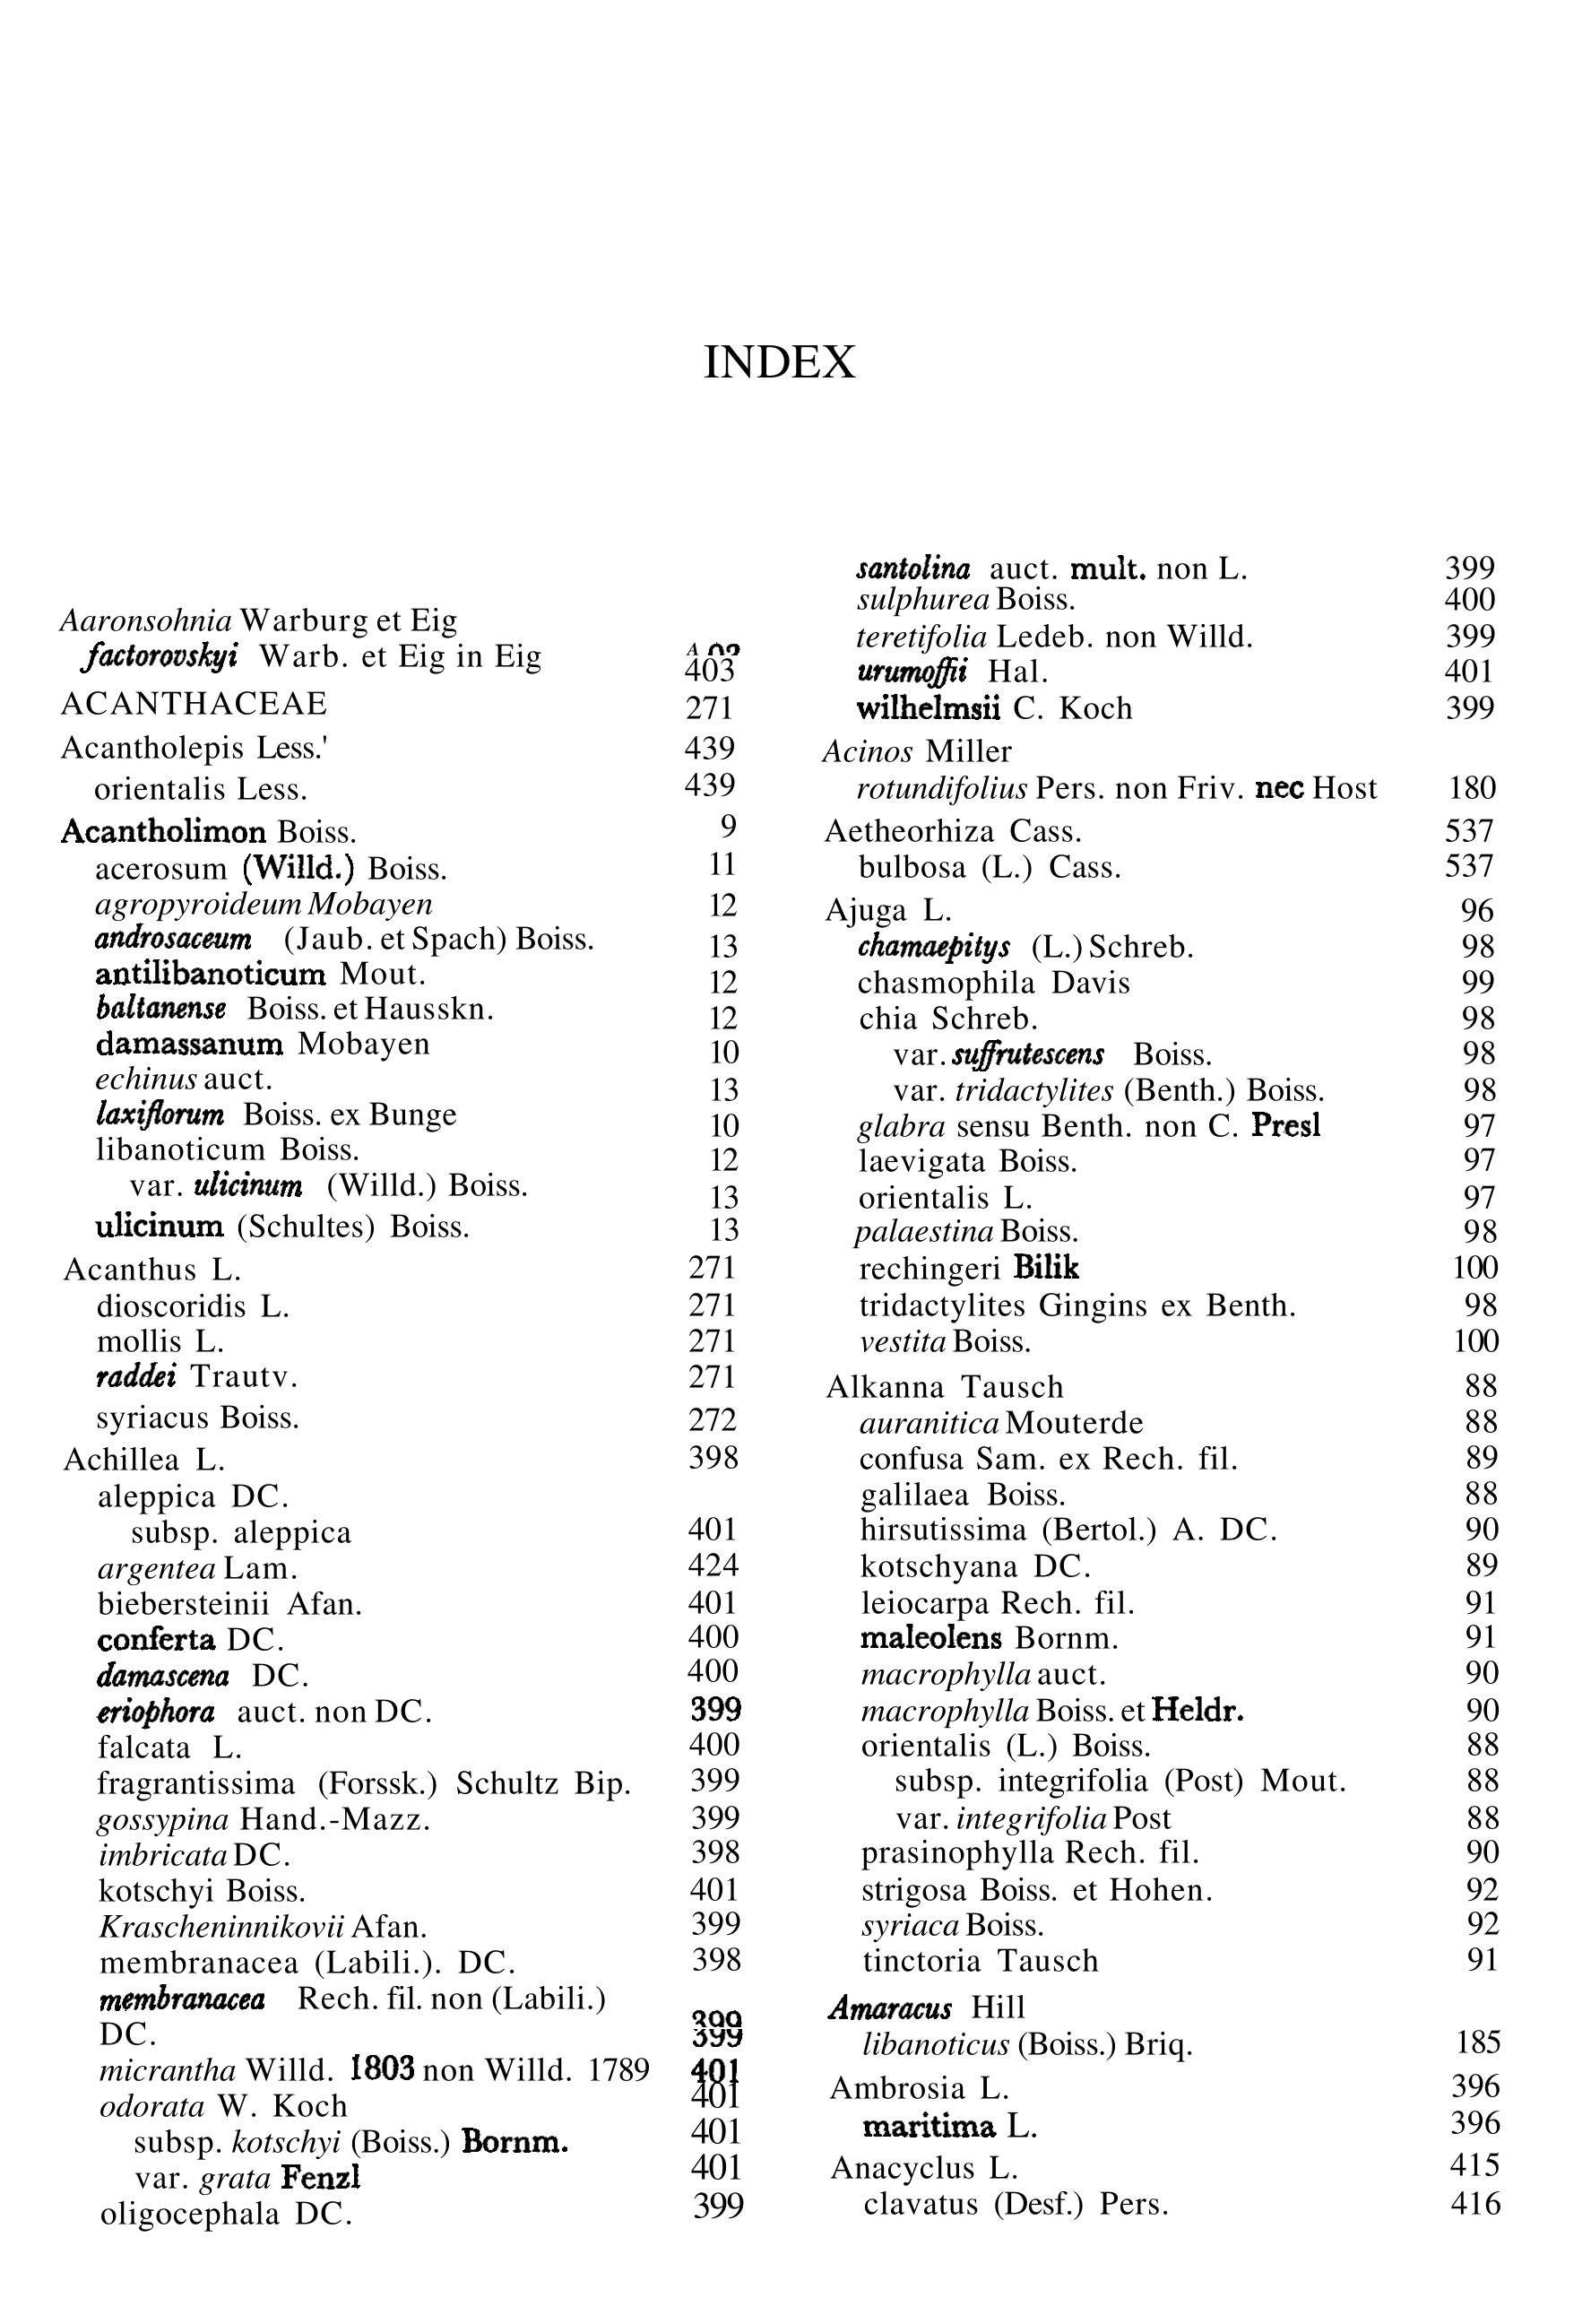

In [153]:
index = list(range(555, 583))
pix_map1 = doc.get_page_pixmap(555,matrix=mat)
image1 = Image.open(io.BytesIO(pix_map1.tobytes()))
draw1 = ImageDraw.Draw(image1)
image1
#plot_genus_blocks(test_df1, draw1)
#plot_epitet_blocks(test_df1, draw1)

100%|██████████| 28/28 [00:29<00:00,  1.07s/it]


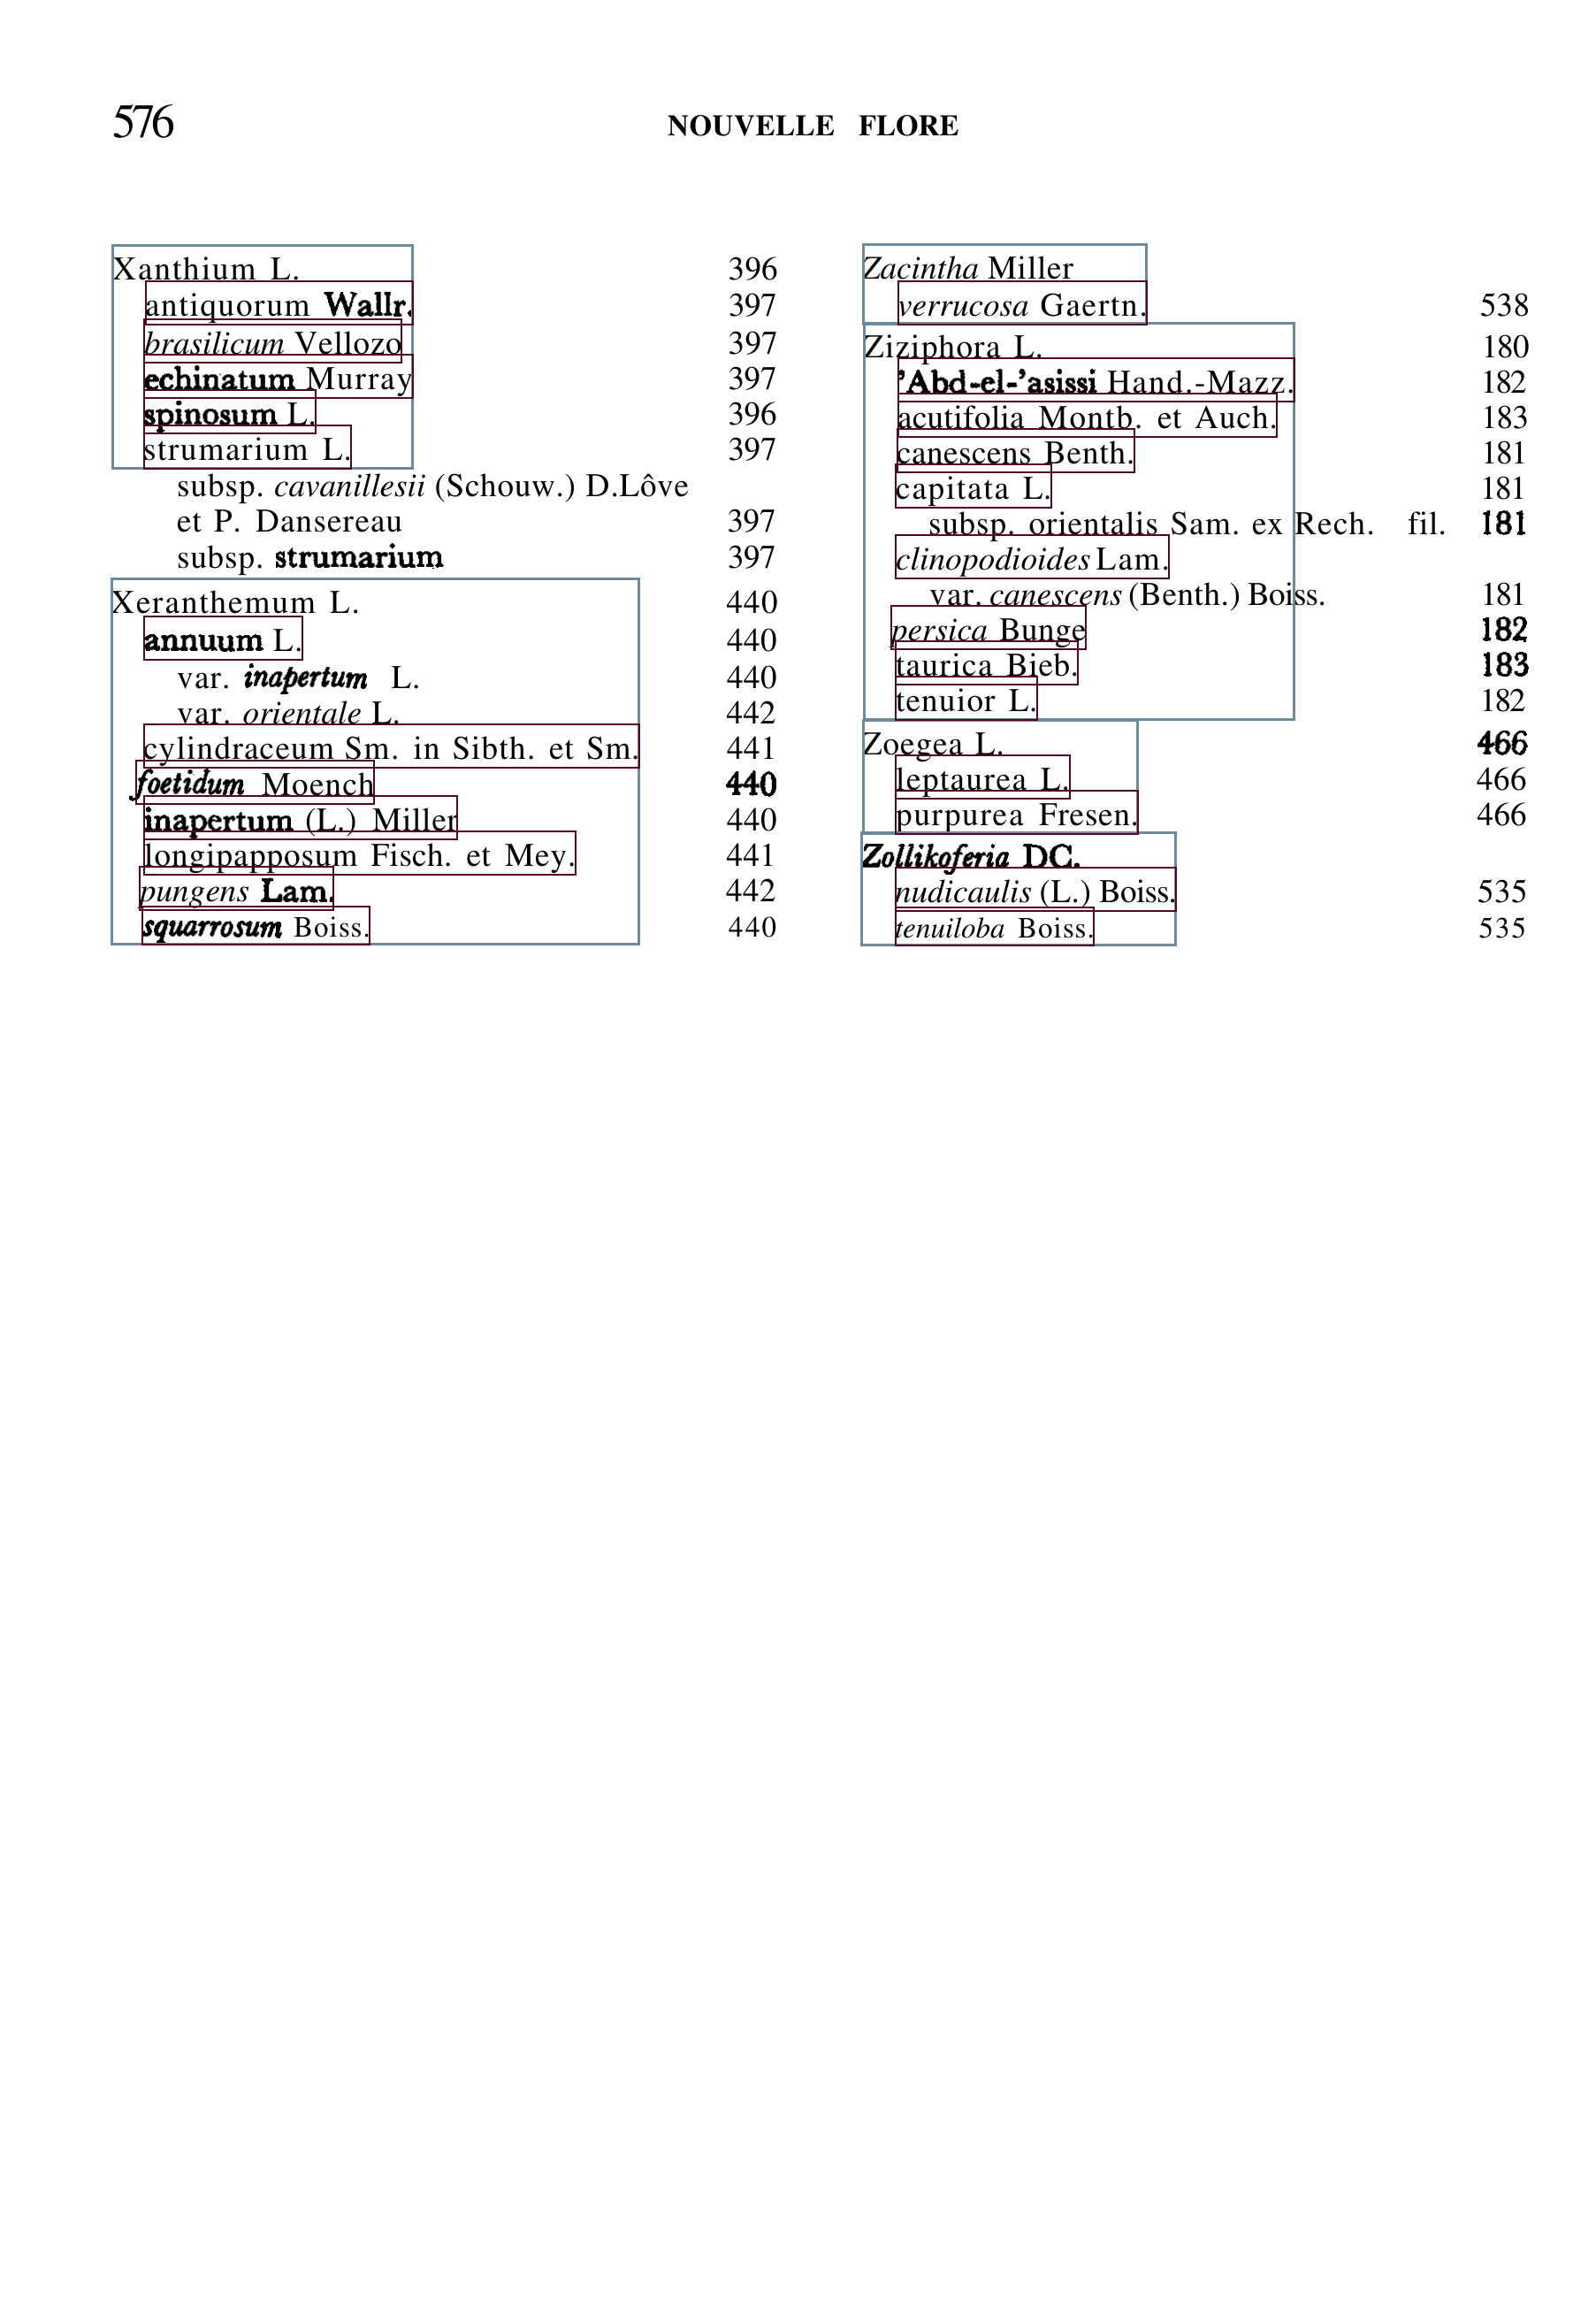

In [154]:
genus = np.NaN
result_ims = []
df_list = []

for page_num in tqdm(index):
    #page_num = 561
    page_df, genus = process_df(page_num, genus)

    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)

    plot_genus_blocks(page_df, draw)
    plot_epitet_blocks(page_df, draw)
    
    df_list.append(page_df)
    result_ims.append(image)
    #break
result_ims[0].save('../output/book3_index_genus_epitet_blocked.pdf',save_all=True, append_images=result_ims[1:])
image


In [155]:
page_df[page_df['genus'] == 'Xeranthemum']

,in_x0,in_y0,in_x1,in_y1,word,block_no,line_no,word_no,page_num,x0,y0,x1,y1,indent_group,col,genus,epitet
32,30.000000,156.882980,85.656815,168.888992,Xeranthemum,9,0,0,582,125.000000,653.679085,356.903394,703.704135,1.0,0,Xeranthemum,NaN
33,89.519798,156.882980,97.604141,168.888992,L.,9,0,1,582,372.999159,653.679085,406.683922,703.704135,NaN,0,Xeranthemum,NaN
35,39.119999,167.202988,70.597992,179.209000,annuum,10,0,0,582,162.999996,696.679115,294.158300,746.704165,2.0,0,Xeranthemum,annuum
36,74.160011,167.202988,82.160202,179.209000,L.,10,0,1,582,309.000047,696.679115,342.334175,746.704165,NaN,0,Xeranthemum,annuum
46,38.880001,196.482986,90.665901,208.488998,cylindraceum,13,0,0,582,162.000004,818.679110,377.774588,868.704160,2.0,0,Xeranthemum,cylindraceum
47,93.495331,196.482986,108.327515,208.488998,Sm.,13,0,1,582,389.563878,818.679110,451.364644,868.704160,NaN,0,Xeranthemum,cylindraceum
48,112.185547,196.482986,119.378891,208.488998,in,13,0,2,582,467.439779,818.679110,497.412046,868.704160,NaN,0,Xeranthemum,cylindraceum
49,122.723114,196.482986,145.223831,208.488998,Sibth.,13,0,3,582,511.346308,818.679110,605.099297,868.704160,NaN,0,Xeranthemum,cylindraceum
50,149.081863,196.482986,155.776245,208.488998,et,13,0,4,582,621.174431,818.679110,649.067688,868.704160,NaN,0,Xeranthemum,cylindraceum
51,159.120453,196.482986,173.633850,208.488998,Sm.,13,0,5,582,663.001887,818.679110,723.474375,868.704160,NaN,0,Xeranthemum,cylindraceum


In [156]:
df = pd.concat(df_list, axis = 0)
df.to_csv('../output/book3_all_df.csv')

In [157]:
def get_author(page_df):
    #pruned_df = page_df[(~page_df['genus'].isnull())].reset_index()
    epitet_names = page_df[~page_df['epitet'].isnull()]['epitet'].unique()
    genus_names = page_df[~page_df['genus'].isnull()]['genus'].unique()
    for i in range(len(page_df['x0'])):
        word = page_df.loc[i, 'word']
        if word in epitet_names:
            #print(word, i)
            s = page_df.loc[i, 'word']
            g = page_df.loc[i, 'genus']
            sub_df = page_df[(page_df['genus'] == g) & (page_df['epitet'] == s) & (page_df['word'] != s)]
            
            merged = sub_df.groupby('epitet')['word'].agg(' '.join).reset_index()
            
            concat_str = np.NaN
            if len(merged.index):
                concat_str = merged['word'].item()
            
            page_df.loc[i, 'author'] = concat_str

        if word in genus_names:
            g = page_df.loc[i, 'genus']
            g_block_no = page_df.loc[i, 'block_no']
            sub_df = page_df[(page_df['genus'] == g) & (page_df['block_no'] == g_block_no) & (page_df['word_no'] != 0) & (page_df['line_no'] == 0)]
            merged = sub_df.groupby('genus')['word'].agg(' '.join).reset_index()
            concat_str = np.NaN
            if len(merged.index):
                print(g, word)
                concat_str = merged['word'].item()
            page_df.loc[i, 'author'] = concat_str

In [158]:
def plot_author_blocks(page_df, draw, color = '#a3a3a3', w = 1):
    epitet_list = page_df['epitet'].unique()
    for c in page_df['col'].unique():
        for s in epitet_list:
            temp_df = page_df[(page_df['col'] == c) & (page_df['epitet'] == s)]
            for g in temp_df['genus'].unique():
                temp_g_df = temp_df[(temp_df['genus'] == g) & (temp_df['word'] != s)]
                a_x0 = temp_g_df['x0'].min()
                a_y0 = temp_g_df['y0'].min()
                a_x1 = temp_g_df['x1'].max()
                a_y1 = temp_g_df['y1'].max()
                
                draw.rectangle((a_x0, a_y0, a_x1, a_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

In [159]:
"""for page_df in df_list:
    get_author(page_df)

df = pd.concat(df_list, axis = 0)
df.to_csv('../output/all_df_v3.csv')

simple_genus_species_author = author_pruned_df[["genus", "species", "author"]]

for page_num in tqdm(range(len(pages))):
    page_df, genus = process_df(page_num, genus)

    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)

    plot_genus_blocks(page_df, draw)
    plot_epitet_blocks(page_df, draw)
    
    df_list.append(page_df)
    result_ims.append(image)
result_ims[0].save('../output/genus_epitet_blocked_indexv3.pdf',save_all=True, append_images=result_ims[1:])
""";

In [160]:
genus = np.NaN
result_ims = []
df_list = []

for page_num in tqdm(index):
    page_df, genus = process_df(page_num, genus)
    get_author(page_df)
    
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)

    plot_genus_blocks(page_df, draw, w = 4)
    plot_epitet_blocks(page_df, draw, w = 3)
    plot_author_blocks(page_df, draw, w = 2)

    df_list.append(page_df)
    result_ims.append(image)
result_ims[0].save('../output/book3_genus_epitet_author_blocked.pdf',save_all=True, append_images=result_ims[1:])


  0%|          | 0/28 [00:00<?, ?it/s]

Aaronsohnia Aaronsohnia
Acantholimon Acantholimon
Acanthus Acanthus
Achillea Achillea
Acinos Acinos
Aetheorhiza Aetheorhiza
Ajuga Ajuga
Alkanna Alkanna
Amaracus Amaracus
Ambrosia Ambrosia
Anacyclus Anacyclus


  4%|▎         | 1/28 [00:01<00:46,  1.74s/it]

Anagallis Anagallis
Anarrhinum Anarrhinum
Anchusa Anchusa
Androsace Androsace
Andryala Andryala
Anoplanthus Anoplanthus
Anthémis Anthémis
Antirrhinum Antirrhinum


  7%|▋         | 2/28 [00:04<01:05,  2.50s/it]

Anvillea Anvillea
Apargia Apargia
Arbutus Arbutus
Arctium Arctium
Armeria Armeria
Arnebia Arnebia
Artemisia Artemisia
Arthrolepis Arthrolepis
Asclepias Asclepias
Asperugo Asperugo
Asperula Asperula
Aster Aster
Asteriscus Asteriscus
Asterolinon Asterolinon
Asyneuma Asyneuma
Atractylis Atractylis
Atropa Atropa
Autrania Autrania
Baceharis Baceharis


 11%|█         | 3/28 [00:06<00:58,  2.33s/it]

Barkhausia Barkhausia
Bartsia Bartsia
Bellardia Bellardia
Bellis Bellis
Bidens Bidens
Blackstonia Blackstonia
Bombycilaena Bombycilaena
Brunnera Brunnera
Bryonia Bryonia
Buglossoides Buglossoides
Buglossum Buglossum
Bungea Bungea
Buphthalmum Buphthalmum
Caccinia Caccinia
Calamintha Calamintha
Calendula Calendula
Calhpeltis Calhpeltis
Calotropis Calotropis
Calystegia Calystegia
Campanula Campanula


 14%|█▍        | 4/28 [00:08<00:52,  2.17s/it]

Carbenia Carbenia
Cardopatium Cardopatium
Carduncellus Carduncellus
Carduus Carduus
Carlina Carlina
Carthamus Carthamus
Catananche Catananche
Celsia Celsia
Centaurea Centaurea


 18%|█▊        | 5/28 [00:10<00:45,  1.96s/it]

Centaurium Centaurium
Centauserratula Centauserratula
Centranthus Centranthus
Cephalaria Cephalaria


 21%|██▏       | 6/28 [00:12<00:41,  1.87s/it]

Cephalorrhynchus Cephalorrhynchus
Cerinthe Cerinthe
Chaenorrhinum Chaenorrhinum
Chamaemelum Chamaemelum
Chamaepeuce Chamaepeuce
Chamomilla Chamomilla
Chardinia Chardinia
Chartolepi Chartolepi
Cheirolepis Cheirolepis
Chlora Chlora
Chondrilla Chondrilla
Chrysanthemum Chrysanthemum
Chrysocoma Chrysocoma
Cicendia Cicendia
Cicerbita Cicerbita
Cichorium Cichorium
Cionura Cionura
Cirsium Cirsium
Cistanche Cistanche
Citrullus Citrullus
Clinopodium Clinopodium
Cnicus Cnicus
Coleostephus Coleostephus
Colsmannia Colsmannia


 25%|██▌       | 7/28 [00:13<00:38,  1.84s/it]

Convolvulus Convolvulus
Conyza Conyza
Coridothymus Coridothymus
Cota Cota
Cotula Cotula
Cousinia Cousinia
Crépis Crépis
Cressa Cressa
Crucianella Crucianella


 29%|██▊       | 8/28 [00:16<00:39,  1.97s/it]

Cruciata Cruciata
Crupina Crupina
Cucumis Cucumis
Cuscuta Cuscuta
Cyclamen Cyclamen
Cymbolaena Cymbolaena
Cymboseris Cymboseris
Cynanchum Cynanchum
Cynara Cynara
Cynoglossum Cynoglossum
Datura Datura
Daumalia Daumalia
Digitalis Digitalis
Diotis Diotis
Dipterocome Dipterocome
Dittrichia Dittrichia
Doronicum Doronicum
Dracocephalum Dracocephalum
Flore Flore


 32%|███▏      | 9/28 [00:18<00:39,  2.09s/it]

Dufresnia Dufresnia
Echinops Echinops
Echinospermum Echinospermum
Echiochilon Echiochilon
Echium Echium
Eclipta Eclipta
Endoptera Endoptera
Eremostachys Eremostachys
Erica Erica
Erythraea Erythraea
Eufragia Eufragia
Eupatorium Eupatorium
Euphrasia Euphrasia
Evax Evax
Fedia Fedia
Filago Filago


 36%|███▌      | 10/28 [00:20<00:35,  1.95s/it]

Fontanesia Fontanesia
Francoeuria Francoeuria
Fraxinus Fraxinus
Galium Galium
Garhadiolus Garhadiolus
Gastrocotyle Gastrocotyle
Gentiana Gentiana


 39%|███▉      | 11/28 [00:21<00:31,  1.86s/it]

Globularia Globularia
Gomphocarpus Gomphocarpus
Goniolimon Goniolimon
Guizotia Guizotia
Gundelia Gundelia
Gymnarrhena Gymnarrhena
Hagioseris Hagioseris
Haradjania Haradjania
Hedypnois Hedypnois
Helichrysum Helichrysum
Heliotropium Heliotropium
Helminthia Helminthia
Heterocaryum Heterocaryum
Hieracium Hieracium


 43%|████▎     | 12/28 [00:23<00:27,  1.73s/it]

Hormuzakia Hormuzakia
Hyoscyamus Hyoscyamus
Hyoseris Hyoseris
Hypochoeris Hypochoeris
Ifloga Ifloga
Inula Inula
Ipomoea Ipomoea
Jurinea Jurinea
Kentropkyllum Kentropkyllum
Kickxia Kickxia
Knautia Knautia
Koelpinia Koelpinia
Lagoseris Lagoseris
Lallemantia Lallemantia
Lamium Lamium


 46%|████▋     | 13/28 [00:24<00:24,  1.63s/it]

Lappa Lappa
Lappula Lappula
Lapsana Lapsana
Lasiopogon Lasiopogon
Launaea Launaea
Laurentia Laurentia
Lavandula Lavandula
Legousia Legousia
Legouzia Legouzia
Leontodon Leontodon
Lesquereuxia Lesquereuxia
Leucanthemum Leucanthemum
Leysera Leysera
Limonium Limonium
Linaria Linaria
Lippia Lippia
Lithodora Lithodora


 50%|█████     | 14/28 [00:26<00:22,  1.63s/it]

Lithospermum Lithospermum
Lobelia Lobelia
Longchampia Longchampia
Lonicera Lonicera
Lycium Lycium
Lycopsis Lycopsis
Lycopus Lycopus
Lysimachia Lysimachia
Majorana Majorana
x x
Mandragora Mandragora
Marrubium Marrubium
Marsdenia Marsdenia
Maruta Maruta
Matricaria Matricaria
Mattia Mattia
Mattiastrum Mattiastrum
Melissa Melissa
Mentha Mentha
Mericarpaea Mericarpaea
Michauxia Michauxia
Microcala Microcala
Micromeria Micromeria


 54%|█████▎    | 15/28 [00:27<00:21,  1.62s/it]

Micropus Micropus
Mindium Mindium
Moltkia Moltkia
Moluccella Moluccella
Moriria Moriria
Mosheovia Mosheovia
Myconia Myconia
Myopordon Myopordon
Myosotis Myosotis
Nepeta Nepeta
Nerium Nerium
Nicandra Nicandra
Nicotiana Nicotiana
Nonea Nonea
Notobasis Notobasis
Odontites Odontites
Oglifa Oglifa
Oldenlandia Oldenlandia


 57%|█████▋    | 16/28 [00:29<00:19,  1.59s/it]

Olea Olea
Omphalodes Omphalodes
Onobroma Onobroma
Onopordum Onopordum
Onosma Onosma
Oporinia Oporinia
Origanum Origanum
Ormenis Ormenis


 61%|██████    | 17/28 [00:31<00:18,  1.64s/it]

Otanthus Otanthus
Pallenis Pallenis
Paracaryum Paracaryum
Parentucellia Parentucellia
Pedicularis Pedicularis
Pentanema Pentanema
Pentapera Pentapera
Periploca Periploca
Petrodavisia Petrodavisia
Phaenopus Phaenopus
Phaeopappus Phaeopappus
Phagnalon Phagnalon
Phelipaea Phelipaea
Phillyrea Phillyrea
Phlomis Phlomis
Phyla Phyla
Phyllocara Phyllocara
Physalis Physalis


 64%|██████▍   | 18/28 [00:32<00:16,  1.66s/it]

Picnomon Picnomon
Picridium Picridium
Picris Picris
Piptocephalum Piptocephalum
Pluchea Pluchea
Podanthum Podanthum
Podonosma Podonosma
Podospermum Podospermum
Postia Postia
Prasium Prasium
Prenanthes Prenanthes
Primula Primula
Prismatocarpus Prismatocarpus


 68%|██████▊   | 19/28 [00:34<00:14,  1.58s/it]

Prunella Prunella
Psychrogeton Psychrogeton
Psylliostachys Psylliostachys
Pterocephalus Pterocephalus
Pterotheca Pterotheca
Ptilostemon Ptilostemon
Ptosimopappus Ptosimopappus
Pulicaria Pulicaria
Putoria Putoria
Pyrethrum Pyrethrum
Reichardia Reichardia
Rhagadiolus Rhagadiolus
Rhaponserratula Rhaponserratula
Rhaponticum Rhaponticum
Rhinanthus Rhinanthus
Rhododendron Rhododendron
Rindera Rindera
Rochelia Rochelia
Rosmarinus Rosmarinus
Rubia Rubia


 71%|███████▏  | 20/28 [00:35<00:12,  1.53s/it]

Salvia Salvia
Sambucus Sambucus
Samolus Samolus
Satureia Satureia
Saulcya Saulcya
Scabiosa Scabiosa
Scariola Scariola
Sclerocaryopsis Sclerocaryopsis
Scolymus Scolymus
Scorzonera Scorzonera


 75%|███████▌  | 21/28 [00:37<00:10,  1.53s/it]

Scrophularia Scrophularia
Senecio Senecio
Seriola Seriola
Serratula Serratula
Sesamum Sesamum
Sherardia Sherardia
Sideritis Sideritis


 79%|███████▊  | 22/28 [00:38<00:09,  1.54s/it]

Siebera Siebera
Silybum Silybum
Siphonostegia Siphonostegia
Solanum Solanum
Solenanthus Solenanthus
Sonchus Sonchus
Specularia Specularia
Stachys Stachys
Staehelina Staehelina
Statice Statice


 82%|████████▏ | 23/28 [00:40<00:07,  1.51s/it]

Stechmannia Stechmannia
Steptorhamphus Steptorhamphus
Stizolophus Stizolophus
Stylocline Stylocline
Symphytum Symphytum
Tagetes Tagetes
Tanacetum Tanacetum
Tapeinanthus Tapeinanthus
Taraxacum Taraxacum
Tetramorphaea Tetramorphaea
Teucrium Teucrium


 86%|████████▌ | 24/28 [00:41<00:06,  1.52s/it]

Tkrineia Tkrineia
Thuspeinanta Thuspeinanta
Thymbra Thymbra
Thymus Thymus
Tolpis Tolpis
Tomanthea Tomanthea
Tracheliopsis Tracheliopsis
Trachelium Trachelium
Trachornitum Trachornitum
Tragopogon Tragopogon
Tripleurospermum Tripleurospermum
Trixago Trixago
Tussilago Tussilago
Tyrimnus Tyrimnus
Urospermum Urospermum
Utricularia Utricularia
Vaillantia Vaillantia
Valeriana Valeriana
Flore Flore


 89%|████████▉ | 25/28 [00:43<00:04,  1.50s/it]

Varthemia Varthemia
Verbascum Verbascum


 93%|█████████▎| 26/28 [00:44<00:03,  1.56s/it]

Verbesina Verbesina
Veronica Veronica
Viburnum Viburnum
Vicoa Vicoa
Vinca Vinca
Vincetoxicum Vincetoxicum
Vitex Vitex
Warburgina Warburgina
Wiedemannia Wiedemannia
Withania Withania


 96%|█████████▋| 27/28 [00:46<00:01,  1.59s/it]

Xanthium Xanthium
Xeranthemum Xeranthemum
Zacintha Zacintha
Ziziphora Ziziphora
Zoegea Zoegea
Zollikoferia Zollikoferia


100%|██████████| 28/28 [00:47<00:00,  1.68s/it]


In [161]:
df = pd.concat(df_list, axis = 0)
df.to_csv('../output/book3_all_df_v3.csv')

In [162]:
author_pruned_df = df[(~df['author'].isnull()) | (df['word'] == df['genus'])]

In [163]:
simple_genus_species_author = author_pruned_df[["genus", "epitet", "author"]]
simple_genus_species_author.to_csv('../output/book3_simple_genus_species_author.csv', index = False)